In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

Common code for all questions

In [2]:
def accuracy(x,y):
    '''To measure SER using accuracy'''
    return (x == y).mean()

def progress_bar(a,b,ET='NA'):
    if not ET is 'NA':
        ET = (b-a)*ET/(a+0.0001)
        ET = int(ET*10)/10
    return print('\rETime left {4}s [{2}] completed {0}/{1} = {3:.1f}%'.format(
                        a,b,'*'*a + '.'*(b-a),100*a/b,ET),end='\t')

def gen_rand_base4(n):
    '''generate array of n symbols each symbol can be [0,3] with probab 0.25'''
    np.random.randint(low=0,high=4,size=n)

def PAM4gen(n,sigma_I=1):
    '''
    generate I(k) ~ Unif( -3d, -d, d, 3d); d  = sqrt(1/5)
    generate -3 -1 1 3 randomly scaled by 1/5
    x = 0 1 2 3    y = 2x-3 = -3 -1 1 3
    I = y/root(5) = 0.4x - 0.6'''
    rand0_3 = np.random.randint(low=0,high=4,size=n)
    return base4toPAM4(rand0_3,sigma_I)

def base4toPAM4(x,sigma_I=1):
    '''map [0,1,2,3] to [-3*d,-d,d,3*d]'''
    d   = np.sqrt(sigma_I/5)
    a,b = 2*d,3*d
    return a*x - b

def PAM4tobase4(x,sigma_I=1):
    '''map [-3*d,-d,d,3*d] to [0,1,2,3]'''
    d   = np.sqrt(sigma_I/5)
    a,b = 2*d,3*d
    return (x + b)/a

Common code for all questions

In [3]:
f_chnl0       = np.array([0.8,-1,0.6])/np.sqrt(2)#channel through which message is sent
PAM4_alphabet = base4toPAM4(np.arange(4))# array of possible PAM4 symbols
init_pad      = PAM4_alphabet[[0,0]]     # the initial memory of channel is assumed as (-3*d,-3*d)

def channel_out(x,f_chnl=f_chnl0,init_pad=init_pad):
    '''function to calculate the output of a filter'''
    x = np.hstack(( init_pad,x ))
    z = np.convolve(x,f_chnl)
    z = z[len(init_pad):len(z)-len(f_chnl)+1]
    return z

def nearest_symbol(x):
    '''return the nearest valid PAM4 symbol'''
    dist = np.abs(x - PAM4_alphabet.reshape(-1,1))
    ii   = np.argmin(dist,axis=0)
    return PAM4_alphabet[ii]

energy of channel = (0.8 x 0.8 + 1 x 1 + 0.6 x 0.6)/2 = 2/2 = 1

variance(I(k)     = 1

SNR = (energy of the channel * variance(I)/noise_variance)

=>SNR = 1*1/noise_variance

=>noise_variance = 1/SNR

# a) Viterbi Algorithm

In [4]:
class viterbi_decoder(object):
    def __init__(self,f_chnl=f_chnl0,tail_bits=PAM4_alphabet[[0,0]],init_pad=PAM4_alphabet[[0,0]]):
        self.L_chnl      = len(f_chnl)      #length of the channel
        self.mem         = self.L_chnl - 1  # memory of the channel
        self.f_chnl      = f_chnl           # coefficients of the channel
        self.tail_bits   = tail_bits        # tails bits for viterbi algorithm
        self.init_pad    = init_pad         # initial L-1 bits stored in the channel

    def trellis_gen(self,rseq):
        '''function to generate the trellis and fill the cumulative metrics'''

        init_memory = tuple(self.init_pad)  # initial L-1 bits stored in the channel
        stage_0       = {init_memory:[0,-1]}# first stage of the trellis
        stages        = [stage_0] + [dict() for i in range(len(rseq))]#create an empty trellis
        f_chnl_part   = self.f_chnl[1:]     #last L-1 coefficients of channel
        
        for stage_index in range(len(rseq)):#for loop to compute the metrics of next stage
            r_true    = rseq[stage_index]
            nxt_stage = stages[stage_index+1] 
            
            tail_index = stage_index - len(rseq) + self.mem
            tmp_alphabet = PAM4_alphabet if tail_index<0 else [self.tail_bits[tail_index]]#to constrain the trellis for tail symbols
            
            for memory,cm in stages[stage_index].items():
                transition_metric_part0 = r_true - np.matmul(f_chnl_part,memory)#partial computation of transition metric for efficiency
                for jPAM4 in tmp_alphabet:
                    tmp_memory           = (jPAM4, *memory[:-1])                    
                    tmp_cm               = cm[0] + (transition_metric_part0 - self.f_chnl[0]*jPAM4)**2##cumulative metric calc
                    if nxt_stage.get(tmp_memory,[1e23,-1])[0] > tmp_cm:##choosing the node which gives the min cumulative metric
                        nxt_stage[tmp_memory] = [tmp_cm,memory[-1]]##[cumulative metric,survivor in previous stage]
        return stages
         
    def decode_inf_delay(self,rseq):
        '''infinite delay Viterbi Algorithm equivalent to MMSE'''
        '''rseq = [r(0) r(1)  ... r(k-2) r(k-1) r(k)]'''
        stages = self.trellis_gen(rseq)#compute all stages in the trellis
        msg = np.zeros(len(rseq))
        symb_index = len(rseq)-1
        
        #find the node in the last stage with minimum cumulative metric
        #will have only one node in the last stage since we are using known tail symbols
        min_key = -1
        min_cm  = float('inf')
        for k,v in stages[-1].items():
            if min_cm > v[0]:
                min_key, min_cm = k, v[0]
          
        curr_memory = min_key
        for stage_index in range(len(stages)-1,0,-1):#traversing backward along the survivor sequence
            msg[symb_index] = (curr_memory[0])
            curr_memory = (*curr_memory[1:],stages[stage_index][curr_memory][1])#find the previous symbol in the suvivor sequence
            symb_index -= 1
        return np.array(msg), min_cm
    
    def decode_finite_delay(self,stages,delta):
        msg = np.zeros(len(stages)-1)
        
        #decoding the first N-Delta symbols of the sequence using fintie delay decoding
        for symb_index in range(len(stages)-1-delta):
            min_key = -1
            min_cm  = float('inf')
            for k,v in stages[symb_index + delta + 1].items():
                if min_cm > v[0]:
                    min_key = k
                    min_cm  = v[0]

            curr_memory = min_key
            for stage_index in range(symb_index + delta + 1,symb_index+1,-1):
                curr_memory = (*curr_memory[1:],stages[stage_index][curr_memory][1])
            msg[symb_index] = curr_memory[0]
        
        #decoding the last Delta symbols using infinite delay decoding
        min_key = -1
        min_cm  = float('inf')
        for k,v in stages[-1].items():
            if min_cm > v[0]:
                min_key, min_cm = k, v[0]
          
        curr_memory = min_key
        for stage_index in range(len(stages)-1,max(len(stages)-1-delta,0),-1):
            msg[stage_index-1] = (curr_memory[0])
            curr_memory = (*curr_memory[1:],stages[stage_index][curr_memory][1])
        return np.array(msg), min_cm
    
    def transition_metric(self,r_true,tap_delay_line):
        '''redundant function'''
        return (r_true - np.matmul(self.f_chnl,tap_delay_line))**2

Viterbi algorithm takes about 5-8 mins(depending on PC) to compute SER for
all 36 combinations of noise variance and Delta

check the progress bar for time left


In [27]:
time1 = time.time()

Delta_arr    = [3,6,15,30]
SNR_arr      = 10**(np.arange(0,16.001,2)/10)
sigma_v2_arr = 1/SNR_arr                # noise variance = 1/SNR
sigma_v_arr  = np.sqrt(sigma_v2_arr)    # noise standard deviation = sqrt(noise variance)
tail_bits    = PAM4_alphabet[[1,2]]     # known tail bits(symbols) for the viterbi algorithm can be changed manually here
init_pad     = np.array([0,0])#PAM4_alphabet[[0,0]] #initial memory of the channel

viterbi0 = viterbi_decoder(f_chnl0,tail_bits,init_pad)

msg_PAM4  = PAM4gen(100000)## generate I(k) ~ Unif(-3*d,-d,d,3*d); d = sqrt(1/5)
msg_PAM4  = np.hstack([msg_PAM4, tail_bits])#add known tail bits

tx_seq    = channel_out(msg_PAM4,f_chnl0,init_pad)#output of the channel without noise
SER_VA    = np.zeros(( len(Delta_arr),len(sigma_v_arr) ))

display_progress = 1
print()
if display_progress: progress_bar(0,len(sigma_v_arr))
for ind_sigma_v,sigma_v in enumerate(sigma_v_arr):
    noise     = np.random.randn(len(msg_PAM4))*sigma_v  #generate noise
    rx_seq    = tx_seq + noise                          #add noise to channel output
    trellis   = viterbi0.trellis_gen(rx_seq)# common trellis generation for different values of delta to simulate faster

    for ind_Delta,Delta in enumerate(Delta_arr):#Decoding with different delays
        est_seq = viterbi0.decode_finite_delay(trellis.copy(),Delta)[0]
        SER_VA[ind_Delta][ind_sigma_v] = 1 - accuracy(msg_PAM4,est_seq)
    if display_progress: progress_bar(ind_sigma_v+1,len(sigma_v_arr),time.time()-time1)
    
time2 = time.time()
print('\ntime for {} symbols = {:.2f} secs = {:.3f} mins'.format(len(msg_PAM4),time2-time1,(time2-time1)/60))


ETime left 0.0s [*********] completed 9/9 = 100.0%		
time for 100002 symbols = 332.37 secs = 5.539 mins


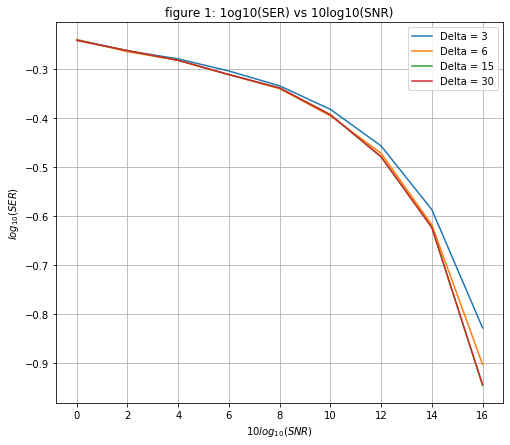

In [6]:
plt.figure(figsize=(8,7))
plt.title('figure 1: 1og10(SER) vs 10log10(SNR)')
for ind_i,Delta in enumerate(Delta_arr):
    # plt.plot(10*np.log10(SNR_arr),SER_VA[ind_i]*100,label='Delta = %d'%(Delta))
    plt.plot(10*np.log10(SNR_arr),np.log10(SER_VA[ind_i]),label='Delta = %d'%(Delta))
plt.xlabel('$10log_{10}(SNR)$')
plt.ylabel('$log_{10}(SER)$')
plt.legend()
plt.grid()
plt.savefig('figure1')

In [7]:
'''Check if the SER of Delta = 15 and Delta =30 are equal'''
print(np.allclose(SER_VA[2],SER_VA[3],atol=1e-3))#check if max difference is  < 0.1 percent 
print(np.abs(SER_VA[2]-SER_VA[3]),np.abs(SER_VA[2]-SER_VA[3]).max())

True
[2.99940012e-04 9.99800040e-05 0.00000000e+00 9.99800040e-05
 0.00000000e+00 1.99960008e-04 5.99880024e-04 1.99960008e-04
 4.99900020e-04] 0.0005998800239952473


**SER values for Delta = 15 and Delta = 30 are almost same** at every SNR

max difference between SER(Delta = 15) and SER(Delta = 30) is **0.09** percent

so for any value of Delta >= 15 the SER is almost same at every SNR

**SER(Delta = 3) > SER(Delta = 10) > SER(Delta = 15) = SER(Delta = 30)** at every SNR

SER decreases(monotonically) with increasing Delta at every SNR

SER decreases with increasing SNR for every Delta

difference in SER is more clear at high SNR


**Linear MMSE Equalizer**

In [8]:
def nearest_symbol(x):
    dist = np.abs(x - PAM4_alphabet.reshape(-1,1))
    ii   = np.argmin(dist,axis=0)
    return PAM4_alphabet[ii]
    
def R_fxn(N,sigma_v2,f_chnl=f_chnl0):
    '''Calculate R Autocorrelation matrix for LMMSE equalizer'''
    if N>len(f_chnl):
        f_chnl = np.hstack([f_chnl,np.zeros(N-len(f_chnl))])
    f_chnl = f_chnl[:N]
    row = [(f_chnl[i:]*f_chnl[:N-i]).sum() for i in range(N)]
    R   = np.diag(np.full(N,fill_value=sigma_v2))
    for i in range(N):
        i1 = N -i
        for j in range(i1):
            R[j][j+i] = R[j+i][j] = R[j+i][j] + row[i]
    return R

def P_fxn(N,Delta,f_chnl=f_chnl0):
    '''Calculate P for LMMSE equalizer'''
    L = len(f_chnl)
    P = np.zeros(N)
    for i in range(N):
        j = Delta - i
        if j >=0 and j<=L-1:
            P[i] = f_chnl[j]
    return P

In [9]:
f_chnl0 = np.array([0.8,-1,0.6])/np.sqrt(2)
sigma_I = 1 ##variance of msg signal = var[I(k)]
PAM4_alphabet = base4toPAM4(np.arange(4),sigma_I=sigma_I)
init_pad      = np.array([0,0])#PAM4_alphabet[[0,0]] ##Initial memory(L-1 bits) stored in the channel

SNR  = 10#( in dB)
SNR  = 10**(SNR/10)
sigma_v2 = 1/SNR
sigma_v  = np.sqrt(sigma_v2)
msg_PAM4 = PAM4gen(int(1e5),sigma_I=sigma_I)
tx_seq   = channel_out(msg_PAM4, f_chnl0, init_pad)       #noiseless output of channel
rx_seq   = tx_seq + sigma_v*np.random.randn(len(msg_PAM4))#add noise with SNR 10dB to the channel output

**B1, B2, B3**

In [10]:
N,Delta = 3,0
for (N,Delta) in [(3,0),(10,0),(10,5)]:
    R,P        = R_fxn(N,sigma_v2,f_chnl0), P_fxn(N,Delta,f_chnl0)  #calculate 
    R_inv      = np.linalg.inv(R)
    W_opt      = np.matmul(R_inv,P)
    W_opt_flat = W_opt.ravel()# flattened view of W_opt

    est_msg    = channel_out(rx_seq,W_opt_flat)
    Jmin       = np.square(msg_PAM4[:len(msg_PAM4)-Delta] - est_msg[Delta:]).mean()
    print('N = {}, Delta = {}'.format(N,Delta))
    print('Jmin simulated   {:.4f}\nJmin theoritical {:.4f}'.format(Jmin, sigma_I**2 - np.matmul(W_opt_flat,P) ))
    print('w_opt:',W_opt_flat)
    print()

N = 3, Delta = 0
Jmin simulated   0.4606
Jmin theoritical 0.4577
w_opt: [0.95869858 0.80157854 0.30092483]

N = 10, Delta = 0
Jmin simulated   0.4482
Jmin theoritical 0.4447
w_opt: [ 0.98162681  0.84173676  0.31296526 -0.08206659 -0.20034628 -0.13712618
 -0.03402374  0.02698237  0.03503563  0.01640834]

N = 10, Delta = 5
Jmin simulated   0.3380
Jmin theoritical 0.3369
w_opt: [ 0.05175672  0.18258482  0.29532074  0.17546218 -0.36100637  0.58939739
  0.64385394  0.30512781  0.01904098 -0.05445636]



**B4**

calculated **Jmin(N,Delta)** varying **N from 2 to 40 and Delta from 0 to 40**.

since N = 1(memory less equalizer) is just scaling the signal it is not considered

In [11]:
N_max = 40 + 1
Jmin_arr  = np.full(( N_max,N_max ),fill_value=3.0)
for N in range(2,N_max):
    for Delta in range(N_max):
         R,P            = R_fxn(N,sigma_v2,f_chnl0), P_fxn(N,Delta,f_chnl0) 
         W_opt_flat     = np.matmul(np.linalg.inv(R),P).ravel()
         Jmin_arr[N][Delta] = sigma_I**2 - W_opt_flat @ P


0.33145583339352125
N values and the Delta for which Jmin is optimal
[[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
 [ 1  1  1  1  3  4  4  4  4  5  5  6  7  8  9  8  8  9  9 11 11 12 12 12
  12 12 14 15 15 16 15 16 16 16 18 19 19 19 19]]


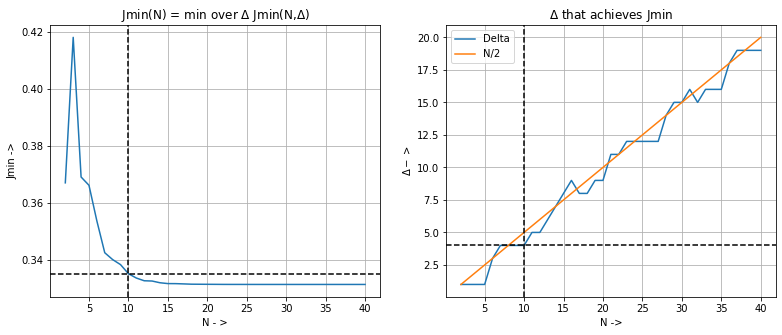

In [12]:
print(Jmin_arr.min())
N_arr = np.arange(N_max)
print('N values and the Delta for which Jmin is optimal')
print(np.vstack([N_arr,Jmin_arr.argmin(axis=1)])[:,2:])

plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('Jmin(N) = min over $\Delta$ Jmin(N,$\Delta$)')
plt.plot(N_arr[2:],Jmin_arr.min(axis=1)[2:])
plt.axvline(x=10,c='k',ls='--')
plt.axhline(y=Jmin_arr[10].min(),c='k',ls='--')
plt.grid()
plt.xlabel('N - >')
plt.ylabel('Jmin ->')

plt.subplot(122)
plt.title('$\Delta$ that achieves Jmin')
plt.plot(N_arr[2:],Jmin_arr.argmin(axis=1)[2:],label='Delta')
plt.plot(N_arr[2:],N_arr[2:]/2,label='N/2')
plt.axvline(x=10,c='k',ls='--')
plt.axhline(y=Jmin_arr.argmin(axis=1)[10],c='k',ls='--')
plt.xlabel('N ->')
plt.ylabel('$\Delta ->$')
plt.grid()
plt.legend()


The value of Delta which minimizes Jmin for a fixed N is close to N/2(right plot)

From the above plots we can see that Jmin(N) decreases with N but almost saturates after N = 20

**Jmin(N=10,Delta=4) = 0.3352;  Jmin(N=20,Delta=9) = 0.3315; Jmin(N=40,Delta=19) = 0.3314;**

we can choose N=40,Delta=19 for optimal filter but the gain in performance compared is only 0.004(Decrease in Jmin)

 which is not worth 4 times the hardware complexity(from N = 10 to N = 40)

 **so N = 10,Delta =4 is chosen as the optimal filter**

In [13]:
print(Jmin_arr[10][4],Jmin_arr[20][9],Jmin_arr[40][19],Jmin_arr.min())
print('best possible Jmin is {}'.format(Jmin_arr.min()))
print('Jmin for the optimal filter chosen is {}'.format(Jmin_arr[10][4]))

0.33523140612210733 0.3315061922677629 0.33145583339352125 0.33145583339352125
best possible Jmin is 0.33145583339352125
Jmin for the optimal filter chosen is 0.33523140612210733


In [14]:
N, Delta  = 10, 4
#### N, Delta  = 20, 9
#### N, Delta  = 60, 30    

# SNR_arr   = np.logspace(0,16/10,9)
SNR_arr     = 10**(np.arange(0,16.0001,2)/10)
SER_LE      = np.zeros(len(SNR_arr))

sigma_v2_arr  = 1/SNR_arr
sigma_v_arr   = np.sqrt(sigma_v2_arr)

msg_PAM4 = PAM4gen(int(1e5),sigma_I=sigma_I)
tx_seq   = channel_out(msg_PAM4, f_chnl0, init_pad)

for ind,sigma_v2 in enumerate(sigma_v2_arr):
    sigma_v    = np.sqrt(sigma_v2)
    R,P        = R_fxn(N,sigma_v2,f_chnl0), P_fxn(N,Delta,f_chnl0)
    R_inv      = np.linalg.inv(R)
    W_opt      = R_inv@P
    W_opt_flat = W_opt.ravel()# flattened view of W_opt
    
    rx_seq     = tx_seq + sigma_v*np.random.randn(len(msg_PAM4))
    est_msg    = channel_out(rx_seq,W_opt_flat)
    est_msg    = nearest_symbol(est_msg)
    msg_PAM4[:len(msg_PAM4)-Delta] - est_msg[Delta:]
    SER_LE[ind] = 1 - accuracy(msg_PAM4[:len(msg_PAM4)-Delta], est_msg[Delta:])
print('SER:',SER_LE,'\naccuracy:',1-SER_LE)

SER: [0.62013481 0.58667347 0.55173207 0.51562062 0.47720909 0.43437738
 0.39318573 0.34569383 0.29795192] 
accuracy: [0.37986519 0.41332653 0.44826793 0.48437938 0.52279091 0.56562262
 0.60681427 0.65430617 0.70204808]


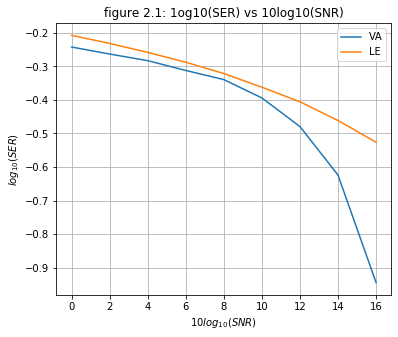

In [15]:
plt.figure(figsize=(6,5))
plt.title('figure 2.1: 1og10(SER) vs 10log10(SNR)')

# plt.plot(10*np.log10(SNR_arr),SER_VA[3]*100, label='VA')
# plt.plot(10*np.log10(SNR_arr),SER_LE*100,    label='LE')

plt.plot(10*np.log10(SNR_arr),np.log10(SER_VA[3]),label='VA')
plt.plot(10*np.log10(SNR_arr),np.log10(SER_LE)   ,label='LE')

plt.xlabel('$10log_{10}(SNR)$')
plt.ylabel('$log_{10}(SER)$')
plt.grid()
plt.legend()

#Observations Linear Equalizer

from the above plot we can see that VA with Delta = 30 is always signficantly better than optimal(almost) Linear Equalizer for any SNR

Since **Viterbi Algorithm (Delta =30) has low SER than optimal LE(N=10,Delta=4) at every SNR(especially at high SNR)**

SER difference between Optimal viterbi and Optimal LE is very high at high SNR

#Decision Feedback Equalizer

In [16]:
class filter(object):
    '''simulates a filter with memory'''
    def __init__(self,imp_res):
        self.imp_res        = np.array(imp_res)
        self.tap_delay_line = np.zeros(self.imp_res.shape)
    
    def out(self,input):
        self.tap_delay_line[1:] = self.tap_delay_line[:-1]
        self.tap_delay_line[0]  = input
        return np.matmul(self.tap_delay_line,self.imp_res)

class DFE(object):
    def __init__(self,wff,wfb):
        '''simulates decision feedback equalizer with the given coefficients'''
        self.reset(wff,wfb)
    
    def reset(self,wff=None,wfb=None):
        if not wff is None: self.wff = wff
        if not wfb is None: self.wfb = wfb
        self.ff  = filter(self.wff)
        self.fb  = filter(self.wfb)
        self.past_output = 0

    def out(self,input):
        tmp = self.ff.out(input) - self.fb.out(self.past_output)
        tmp = self.nearest_symbol(tmp)
        self.past_output = tmp
        return tmp
    
    def seq_out(self,rx_seq):
        tmp = np.zeros(len(rx_seq))
        for i in range(len(tmp)):
            tmp[i] = self.out(rx_seq[i])
        return tmp

    def nearest_symbol(self,x):
        dist = np.abs(x - PAM4_alphabet.reshape(-1,1))
        ii   = np.argmin(dist,axis=0)
        return PAM4_alphabet[ii]

# ff = filter([1,1,0])
# for i in range(1,4):
#     print(ff.out(i))

In [17]:
def corr_fxn2(i,j,f_chnl):
    '''returns E[r(k-i) x I(k-j)]'''
    #r(k-i) I(k-j)  j is less than equal to i
    diff = j - i
    if diff >=0 and diff<= len(f_chnl) - 1:
        return f_chnl[diff]
    return 0

def R_fxn2(N1,N2,sigma_v2,f_chnl=f_chnl0):
    '''R matrix for Decision Feedback Equalizer'''
    A1 = R_fxn(N1,sigma_v2,f_chnl)
    A4 = np.diag(np.full(N2,fill_value=1))
    A2 = np.zeros(( N1,N2 ))
    A3 = np.zeros(( N2,N1 ))

    for i in range(N1):
        for j in range(N2):
            A3[j][i] = A2[i][j] = -corr_fxn2(i,Delta+1+j,f_chnl)
    # print(A2,'\n',A3)
    return np.vstack([ np.hstack([A1,A2]), np.hstack([A3,A4]) ])

def P_fxn2(N1,N2,Delta,f_chnl=f_chnl0):
    '''P matrix for Decision Feedback Equailzer'''
    L = len(f_chnl)
    P = np.zeros(N1+N2)
    for i in range(N1):
        P[i] = corr_fxn2(i,Delta,f_chnl)#P[i] = E[r(k-i)I(k-Delta)]
    return P

In [18]:
f_chnl0 = np.array([0.8,-1,0.6])/np.sqrt(2)
sigma_I = 1 
PAM4_alphabet = base4toPAM4(np.arange(4),sigma_I=sigma_I)
init_pad = PAM4_alphabet[[0,0]]

SNR  = 10#( in dB)
SNR  = 10**(SNR/10)
sigma_v2 = 1/SNR
sigma_v  = np.sqrt(sigma_v2)
msg_PAM4 = PAM4gen(int(1e5),sigma_I=sigma_I)
# msg_PAM4 = PAM4gen(int(3e1),sigma_I=sigma_I)
tx_seq   = channel_out(msg_PAM4, f_chnl0, init_pad)
rx_seq   = tx_seq + sigma_v*np.random.randn(len(msg_PAM4))

#C1 C2

In [19]:
N1,N2,Delta = 6,4,0
for (N1,N2,Delta) in [(6,4,0),(6,4,3)]:
    R,P        = R_fxn2(N1,N2,sigma_v2,f_chnl0), P_fxn2(N1,N2,Delta,f_chnl0)
    R_inv      = np.linalg.inv(R)
    W_opt      = np.matmul(R_inv,P)
    W_opt_flat = W_opt.ravel()# flattened view of W_opt
    W_ff,W_fb  = np.hsplit(W_opt_flat,[N1])
    # print(W_ff,W_fb)

    DFE0       = DFE(W_ff,W_fb)
    est_msg    = DFE0.seq_out(rx_seq)
    # msg_PAM4   = nearest_symbol(msg_PAM4)
    Jmin       = np.square(msg_PAM4[:len(msg_PAM4)-Delta] - est_msg[Delta:]).mean()
    print('N1 = {}, N2 = {}, Delta = {}'.format(N1,N2,Delta))
    print('Jmin simulated   {:.4f}\nJmin theoritical {:.4f}'.format(Jmin, sigma_I**2 - W_opt_flat @ P))
    print('w_opt:',W_opt_flat)
    print()

N1 = 6, N2 = 4, Delta = 0
Jmin simulated   0.5738
Jmin theoritical 0.2381
w_opt: [ 1.34687006e+00  7.25080752e-16  1.99103042e-16  4.66147705e-17
  3.66317007e-17  2.71738925e-17 -9.52380952e-01  5.71428571e-01
  2.21935568e-16  8.33033345e-17]

N1 = 6, N2 = 4, Delta = 3
Jmin simulated   0.4443
Jmin theoritical 0.1796
w_opt: [ 6.07156583e-02 -2.99095927e-02 -3.65516413e-01  1.01585039e+00
 -2.15427018e-16  6.70935082e-16 -8.73390177e-01  4.30988818e-01
 -5.74628545e-16  3.05788119e-16]



#C3

calculated Jmin(N,Delta) varying N1 from 1 to 9 and Delta from 0 to 10.

since N1 = 1(memory less equalizer) is just scaling the signal it is not considered

In [20]:
# N1+N2 = 10
Delta_max = 10
Jmin_DFE_arr = np.full(( 10,Delta_max ),fill_value=10.0,dtype=np.float)
for N1 in range(1,10): #N1 from 1 to 9
    N2 = 10 - N1       #N2 from 9 to 1
    for Delta in range(Delta_max):
        R,P        = R_fxn2(N1,N2,sigma_v2,f_chnl0), P_fxn2(N1,N2,Delta,f_chnl0)
        R_inv      = np.linalg.inv(R)
        W_opt      = np.matmul(R_inv,P)
        W_opt_flat = W_opt.ravel()# flattened view of W_opt
        tmp        = 1 - np.matmul(W_opt_flat,P)#sigma_I**2 - W_opt_flat @ P
        tmp        = tmp if tmp>0 else 10# if Jmin < 0 set it 10(since -ve Jmin implies formula is invalid)
        Jmin_DFE_arr[N1][Delta] = tmp

0.17372072544483863
[[1 2 3 4 5 6 7 8 9]
 [2 2 2 3 4 5 6 7 4]]
[[1.         2.         3.         4.         5.         6.
  7.         8.         9.        ]
 [0.57142857 0.3218126  0.18163147 0.17957867 0.17525337 0.17387811
  0.17385976 0.17372073 0.21390243]]


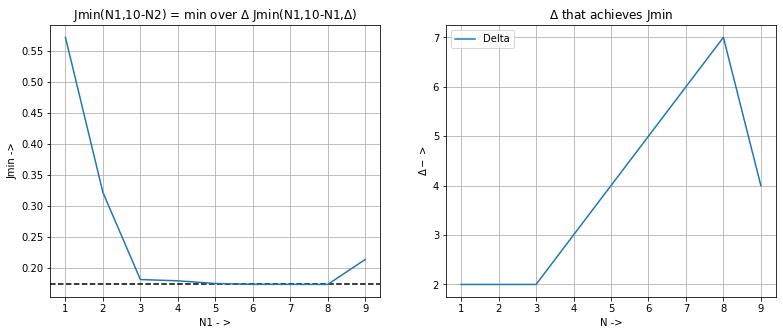

In [21]:
print(Jmin_DFE_arr.min())
N_arr = np.arange(10)
print(np.vstack([N_arr,Jmin_DFE_arr.argmin(axis=1)])[:,1:])
print(np.vstack([N_arr,Jmin_DFE_arr.min(axis=1)])[:,1:])

plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('Jmin(N1,10-N2) = min over $\Delta$ Jmin(N1,10-N1,$\Delta$)')
plt.axhline(y=Jmin_DFE_arr.min(),c='k',ls='--')
plt.plot(N_arr[1:],Jmin_DFE_arr.min(axis=1)[1:])
plt.grid()
plt.xlabel('N1 - >')
plt.ylabel('Jmin ->')
plt.subplot(122)
plt.title('$\Delta$ that achieves Jmin')
plt.plot(N_arr[1:],Jmin_DFE_arr.argmin(axis=1)[1:],label='Delta')
# plt.plot(N_arr[1:],N_arr[1:]/2,label='N/2')
plt.xlabel('N ->')
plt.ylabel('$\Delta ->$')
plt.grid()
plt.legend()

In [22]:
N1_Jmin = Jmin_DFE_arr.min(axis=1).argmin()
Delta_N1_Jmin = Jmin_DFE_arr[N1_Jmin].argmin()
print('optimal filter for DFE is N1={} N2={} Delta={} Jmin={}'.format(
    N1_Jmin,10-N1_Jmin,Delta_N1_Jmin,Jmin_DFE_arr.min()))
print()

optimal filter for DFE is N1=8 N2=2 Delta=7 Jmin=0.17372072544483863



From the above plots(left) we can see that Jmin(N1,10-N2) is minimum at N1 = 8,N2 = 2,

value of Delta which minimises Jmin for N1 = 8 is 7

**The optimal DFE filter for N1+N2 = 10 is N1=8 N2=2 Delta=7 Jmin=0.17372072544483863**

#C4

In [23]:
N1, N2, Delta  = 8, 2, 7

# SNR_arr   = np.logspace(0,16/10,9)
SNR_arr     = 10**(np.arange(0,16.0001,2)/10)
SER_DFE      = np.zeros(len(SNR_arr))

sigma_v2_arr  = 1/SNR_arr
sigma_v_arr   = np.sqrt(sigma_v2_arr)

msg_PAM4 = PAM4gen(int(1e5),sigma_I=sigma_I)
tx_seq   = channel_out(msg_PAM4, f_chnl0, init_pad)

for ind,sigma_v2 in enumerate(sigma_v2_arr):
    sigma_v    = np.sqrt(sigma_v2)
    R,P        = R_fxn2(N1,N2,sigma_v2,f_chnl0), P_fxn2(N1,N2,Delta,f_chnl0)
    R_inv      = np.linalg.inv(R)
    W_opt      = R_inv@P
    W_opt_flat = W_opt.ravel()# flattened view of W_opt
    W_ff,W_fb  = np.hsplit(W_opt_flat,[N1])

    rx_seq     = tx_seq + sigma_v*np.random.randn(len(msg_PAM4))

    DFE0       = DFE(W_ff,W_fb)
    est_msg    = DFE0.seq_out(rx_seq)
    Jmin       = np.square(msg_PAM4[:len(msg_PAM4)-Delta] - est_msg[Delta:]).mean()

    SER_DFE[ind] = 1 - accuracy(msg_PAM4[:len(msg_PAM4)-Delta], est_msg[Delta:])
print('SER',SER_LE,'\naccuracy',1-SER_LE)

SER [0.62013481 0.58667347 0.55173207 0.51562062 0.47720909 0.43437738
 0.39318573 0.34569383 0.29795192] 
accuracy [0.37986519 0.41332653 0.44826793 0.48437938 0.52279091 0.56562262
 0.60681427 0.65430617 0.70204808]


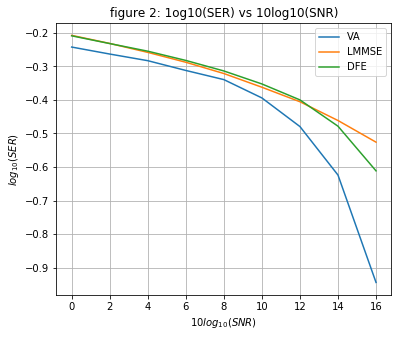

In [24]:
plt.figure(figsize=(6,5))
plt.title('figure 2: 1og10(SER) vs 10log10(SNR)')

## plt.plot(10*np.log10(SNR_arr),SER_VA[3]*100, label='VA')
## plt.plot(10*np.log10(SNR_arr),SER_LE*100,    label='LMMSE')
## plt.plot(10*np.log10(SNR_arr),SER_DFE*100,   label='DFE')

plt.plot(10*np.log10(SNR_arr),np.log10(SER_VA[3]),label='VA')
plt.plot(10*np.log10(SNR_arr),np.log10(SER_LE)   ,label='LMMSE')
plt.plot(10*np.log10(SNR_arr),np.log10(SER_DFE)  ,label='DFE')

plt.xlabel('$10log_{10}(SNR)$')
plt.ylabel('$log_{10}(SER)$')
plt.grid()
plt.legend()

# plt.savefig('figure2')

#Observations DFE

**Viterbi** with Delta = 30 **is better** than both LMMSE and DFE at all SNRs

**At low SNR the performance of optimal LE and optimal DFE is almost same.**

**At high SNR DFE is significantly better than LE** this is probably because of **less error propagation** (from nearest neighbour decisions)**at High SNR**

since The nearest neighbour decision is more accurate at high SNR

#Bonus Question

10 tap LE   N = 10 Delta = 4

10 tap DFE  N1 = 8, N2 = 2, Delta = 7

**Effective channel response**(from combining channel and Equalizer)

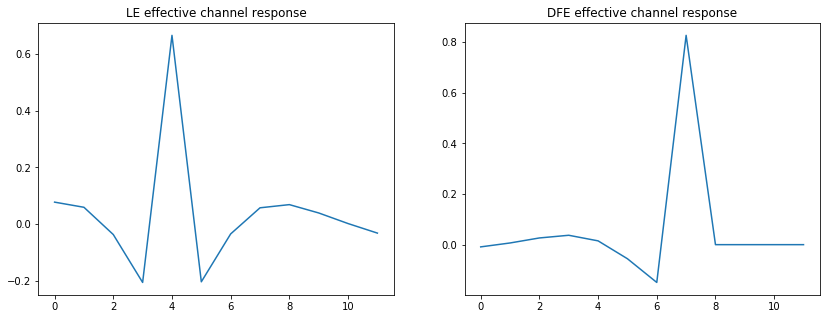

In [25]:
Delta_LE       = 4
N1, Delta_DFE  = 8, 7


SNR = 10**(10/10)
sigma_v2  = 1/SNR
sigma_v   = np.sqrt(sigma_v2)

R_LE,P_LE        = R_fxn(10,sigma_v2,f_chnl0),  P_fxn(10,Delta_LE,f_chnl0)
W_opt_LE         = np.matmul(np.linalg.inv(R_LE),P_LE).ravel()

R_DFE,P_DFE      = R_fxn2(N1,10-N1,sigma_v2,f_chnl0), P_fxn2(N1,10-N1,Delta_DFE,f_chnl0)
W_opt_DFE        = np.matmul(np.linalg.inv(R_DFE),P_DFE).ravel()
Wff, Wfb         = np.hsplit(W_opt_DFE,[N1])

eff_res_LE       = np.convolve(f_chnl0, W_opt_LE)
eff_res_DFE      = np.convolve(f_chnl0, Wff) 

kk  =  Delta_DFE + 1
eff_res_DFE      = np.hstack(( eff_res_DFE,np.zeros(12-len(eff_res_DFE)) ))
eff_res_DFE     -= np.hstack(( np.zeros(kk),Wfb,np.zeros(2 + N1 - kk) ))# removing post cursor ISI by subtracting Wfb 

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title('LE effective channel response')
plt.plot(eff_res_LE,label='eff_LE')
plt.subplot(122)
plt.title('DFE effective channel response')
plt.plot(eff_res_DFE,label='eff_DFE')
# plt.legend()
# plt.figure()
# plt.title('eff_res_DFE - eff_res_LE')
# plt.plot(eff_res_DFE - eff_res_LE)

The post cursor ISI is very less for DFE because of FB

**Residual Inter symbol Interference calculation**


Residual ISI = **sum of square** of coefficients**(except cursor** i.e, the coefficient with highest magnitude**)** of the effective channel

cursor is the coefficient with highest magnitude and it will be at **k = Delta**

In [26]:
print('Residual ISI values are:')
for i in ['eff_res_LE', 'eff_res_DFE']:
    tmp = eval(i).copy()
    tmp[tmp == tmp.max()] = 0
    # print(tmp)
    # print(i,np.square(tmp).sum(),np.var(tmp),np.abs(tmp).sum(),(tmp).sum())
    print('{}\tISI {}'.format(i,np.square(tmp).sum()))

Residual ISI values are:
eff_res_LE	ISI 0.1059923099919701
eff_res_DFE	ISI 0.027764447085367894


**LE    ISI = 0.1059923099919701**

**DFE   ISI =  0.027764447085367894**